In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import efficientnet
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = Path(".")
data_path = path / ".." / ".." / ".." / "Dataset" / "Sipakmed Dataset" / "wsi_dataset"
data_path.ls()

[PosixPath('../../../Dataset/Sipakmed Dataset/wsi_dataset/train'),
 PosixPath('../../../Dataset/Sipakmed Dataset/wsi_dataset/test')]

In [4]:
data_init = (ImageList.from_folder(data_path / "train")
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (966 items)
x: ImageList
Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [6]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=60.0, max_zoom=1.0)

In [7]:
def model_callback(model, model_name):
    return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

In [8]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f832959bc80>>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

In [9]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [10]:
def get_fold_data(fold_idxs, img_size, bs=16):
    return (ImageList.from_folder(data_path / "train")
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=img_size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

# Fold-1

In [12]:
fold_data = get_fold_data(idxs[0], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (772 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (194 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [13]:
learner = cnn_learner(fold_data, models.vgg19_bn, metrics=our_metrics).to_fp16()
learner

Learner(data=ImageDataBunch;

Train: LabelList (772 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (194 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


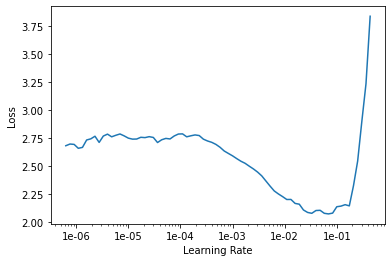

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
learner.fit_one_cycle(30, max_lr=slice(4e-03), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold1-stage1"))
learner.save("last-vgg19-sipak-multiclass-fold1-stage1")

Better model found at epoch 0 with accuracy value: 0.6443299055099487.
Better model found at epoch 1 with accuracy value: 0.8144329786300659.
Better model found at epoch 2 with accuracy value: 0.8298969268798828.
Better model found at epoch 3 with accuracy value: 0.8608247637748718.
Better model found at epoch 4 with accuracy value: 0.8711340427398682.
Better model found at epoch 5 with accuracy value: 0.8814433217048645.
Better model found at epoch 6 with accuracy value: 0.8865979313850403.
Better model found at epoch 8 with accuracy value: 0.8917526006698608.
Better model found at epoch 9 with accuracy value: 0.9175257682800293.
Better model found at epoch 12 with accuracy value: 0.9329897165298462.
Better model found at epoch 13 with accuracy value: 0.9536082744598389.
Better model found at epoch 16 with accuracy value: 0.969072163105011.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


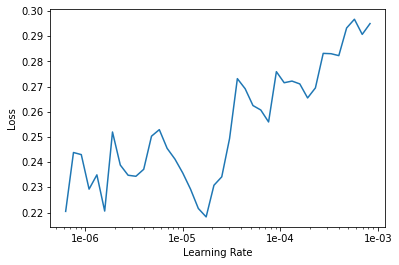

In [16]:
learner.load("best-vgg19-sipak-multiclass-fold1-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [17]:
learner.fit_one_cycle(30, max_lr=slice(1e-05), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold1-stage2"))
learner.save("last-vgg19-sipak-multiclass-fold1-stage2")

Better model found at epoch 0 with accuracy value: 0.969072163105011.
Better model found at epoch 14 with accuracy value: 0.9742268323898315.


# Fold-2

In [18]:
fold_data = get_fold_data(idxs[1], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


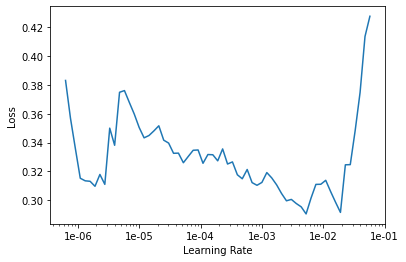

In [19]:
learner.load("best-vgg19-sipak-multiclass-fold1-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(30, max_lr=slice(1.9e-03), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold2-stage1"))
learner.save("last-vgg19-sipak-multiclass-fold2-stage1")

Better model found at epoch 0 with accuracy value: 0.984455943107605.
Better model found at epoch 1 with accuracy value: 0.9896373152732849.
Better model found at epoch 3 with accuracy value: 0.9948186278343201.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


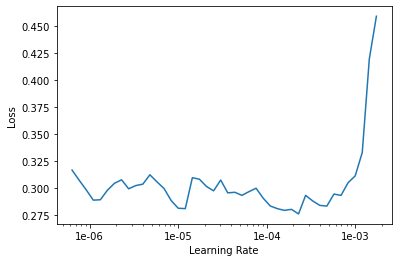

In [21]:
learner.load("best-vgg19-sipak-multiclass-fold2-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [22]:
learner.fit_one_cycle(30, max_lr=slice(1e-04), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold2-stage2"))
learner.save("last-vgg19-sipak-multiclass-fold2-stage2")

Better model found at epoch 0 with accuracy value: 0.9740932583808899.
Better model found at epoch 1 with accuracy value: 0.984455943107605.
Better model found at epoch 4 with accuracy value: 0.9896373152732849.


# Fold-3

In [23]:
fold_data = get_fold_data(idxs[2], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


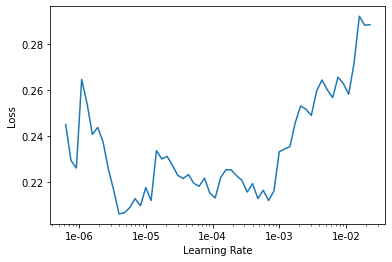

In [24]:
learner.load("best-vgg19-sipak-multiclass-fold2-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [25]:
learner.fit_one_cycle(30, max_lr=slice(2.2e-06), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold3-stage1"))
learner.save("last-vgg19-sipak-multiclass-fold3-stage1")

Better model found at epoch 0 with accuracy value: 0.984455943107605.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


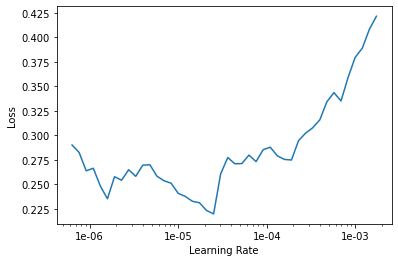

In [26]:
learner.load("best-vgg19-sipak-multiclass-fold3-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(30, max_lr=slice(1.7e-05), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold3-stage2"))
learner.save("last-vgg19-sipak-multiclass-fold3-stage2")

Better model found at epoch 0 with accuracy value: 0.984455943107605.


# Fold-4

In [28]:
fold_data = get_fold_data(idxs[3], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [31]:
learner.load("best-vgg19-sipak-multiclass-fold3-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [32]:
learner.fit_one_cycle(30, max_lr=slice(7e-07), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold4-stage1"))
learner.save("last-vgg19-sipak-multiclass-fold4-stage1")

Better model found at epoch 0 with accuracy value: 0.9792746305465698.
Better model found at epoch 3 with accuracy value: 0.984455943107605.
Better model found at epoch 7 with accuracy value: 0.9896373152732849.
Better model found at epoch 15 with accuracy value: 0.9948186278343201.


In [33]:
learner.load("best-vgg19-sipak-multiclass-fold4-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [34]:
learner.fit_one_cycle(30, max_lr=slice(2.5e-06), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold4-stage2"))
learner.save("last-vgg19-sipak-multiclass-fold4-stage2")

Better model found at epoch 0 with accuracy value: 0.984455943107605.
Better model found at epoch 1 with accuracy value: 0.9896373152732849.
Better model found at epoch 5 with accuracy value: 0.9948186278343201.


# Fold-5

In [35]:
fold_data = get_fold_data(idxs[4], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


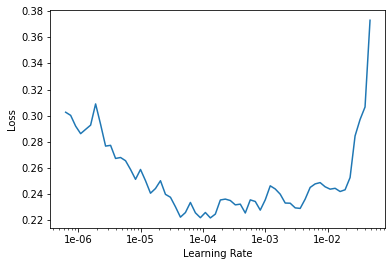

In [36]:
learner.load("best-vgg19-sipak-multiclass-fold4-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [37]:
learner.fit_one_cycle(30, max_lr=slice(2.5e-05), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold5-stage1"))
learner.save("last-vgg19-sipak-multiclass-fold5-stage1")

Better model found at epoch 0 with accuracy value: 0.9896373152732849.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


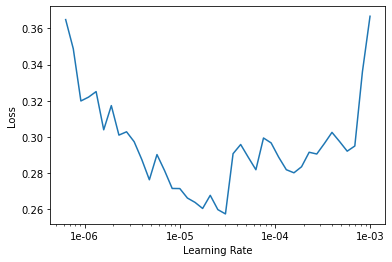

In [39]:
learner.load("best-vgg19-sipak-multiclass-fold5-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [40]:
learner.fit_one_cycle(30, max_lr=slice(1.3e-05), callbacks=model_callback(learner, "best-vgg19-sipak-multiclass-fold5-stage2"))
learner.save("last-vgg19-sipak-multiclass-fold5-stage2")

Better model found at epoch 0 with accuracy value: 0.9896373152732849.


# Testing on 30 images (in valid folder)

In [74]:
all_data = (ImageList.from_folder(data_path)
            .split_by_folder(train="train", valid="test")
            .label_from_folder()
            .transform(None, size=224)
            .databunch(bs=1)
            .normalize(imagenet_stats))
all_data

ImageDataBunch;

Train: LabelList (966 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset;

Valid: LabelList (29 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset;

Test: None

In [112]:
imgs, labels = all_data.valid_ds.x, all_data.valid_ds.y
binary_classes = ["Abnormal", "Benign", "Normal"]

In [113]:
def get_label(label):
    if "abnormal" in label:
        return "Abnormal"
    elif "normal" in label:
        return "Normal"
    elif "benign" in label:
        return "Benign"

y_preds, y_true = [], []
for img, label in zip(imgs, labels):
    y_true.append(get_label(str(label)))
    y_preds.append(get_label(str(learner.predict(img)[0])))

In [118]:
multi_y_preds, multi_y_true = [], []
for img, label in zip(imgs, labels):
    multi_y_true.append(str(label))
    multi_y_preds.append(str(learner.predict(img)[0]))

In [124]:
multi_classes = all_data.classes
multi_classes

['abnormal_Dyskeratotic',
 'abnormal_Koilocytotic',
 'benign_Metaplastic',
 'normal_Parabasal',
 'normal_Superficial-Intermediate']

In [131]:
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

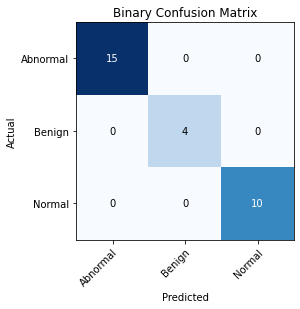

In [132]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_preds, classes=binary_classes, title='Binary Confusion Matrix')
plt.show()

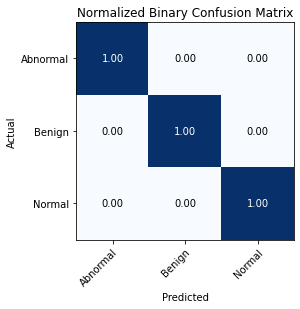

In [133]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_preds, normalize=True, classes=binary_classes, 
                      title='Normalized Binary Confusion Matrix')
plt.show()

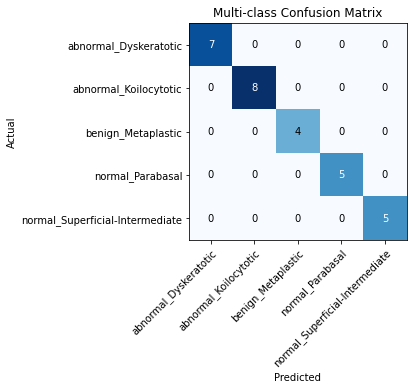

In [134]:
# Plot normalized confusion matrix
plot_confusion_matrix(multi_y_true, multi_y_preds, normalize=False, classes=multi_classes, 
                      title='Multi-class Confusion Matrix')
plt.show()

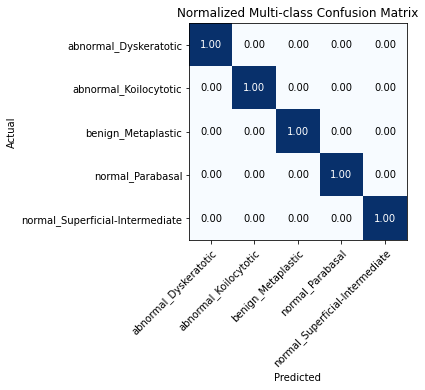

In [135]:
# Plot normalized confusion matrix
plot_confusion_matrix(multi_y_true, multi_y_preds, normalize=True, classes=multi_classes, 
                      title='Normalized Multi-class Confusion Matrix')
plt.show()

# Results (first save results.csv)

In [51]:
def compute_results(fname):
    df = pd.read_csv(fname)
    print(df)
    print("*-*" * 10)
    print("Results :-")
    mean_df = np.mean(df, axis=0)
    mean_error_df = np.mean(np.abs(mean_df - df), axis=0)
    for col, mean, error in zip(list(df.columns), list(mean_df.values), list(mean_error_df.values)):
        print(f"{col.capitalize()} : {mean * 100:.4f} % | { error * 100:.4f} %")

compute_results("results.csv")

   accuracy  precision    recall    f_beta  kappa_score
0  0.974227   0.975648  0.979638  0.978737     0.980618
1  0.989637   0.992000  0.991751  0.991720     0.996911
2  0.984456   0.988437  0.987121  0.987288     0.990706
3  0.994819   0.995652  0.996296  0.996141     0.993885
4  0.989637   0.988141  0.992593  0.991595     0.992423
*-**-**-**-**-**-**-**-**-**-*
Results :-
Accuracy : 98.6555 % | 0.5771 %
Precision : 98.7976 % | 0.4931 %
Recall : 98.9480 % | 0.4880 %
F_beta : 98.9096 % | 0.4867 %
Kappa_score : 99.0909 % | 0.4197 %


# Export Model

In [11]:
fold_data = get_fold_data(idxs[4], img_size=224, bs=16)
export_learner = cnn_learner(fold_data, models.vgg19_bn, metrics=our_metrics).to_fp16()
export_learner.load("best-vgg19-sipak-multiclass-fold5-stage2")
export_learner

Learner(data=ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [12]:
export_learner.freeze()
export_learner.export("best-vgg19-multiclass-sipak.pkl")